# Test Field

## 1-D Multi Value Functions

In [1]:
# utility 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper


Device: cuda


True


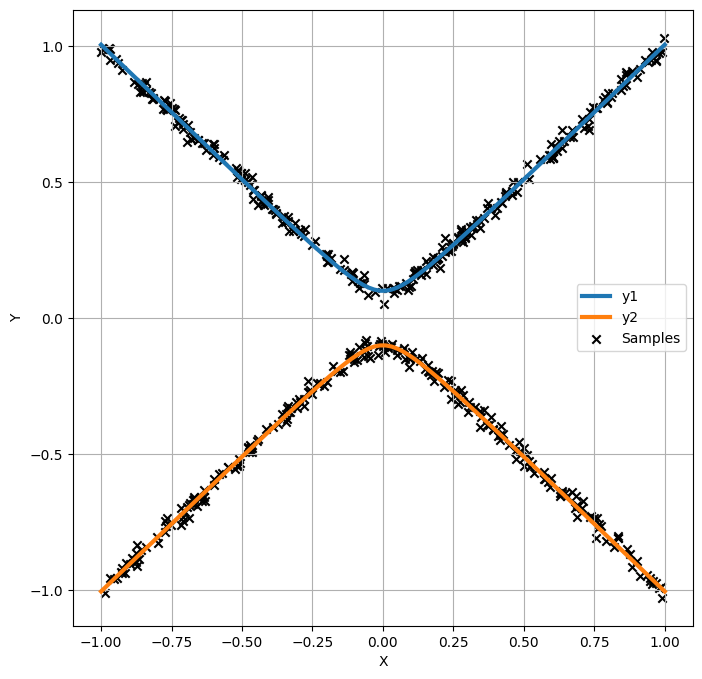

In [2]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

def y_parabola(x, a = 1):
    return a * x**2, -a * x**2

y_multi = y_hyperbola

# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
# plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()



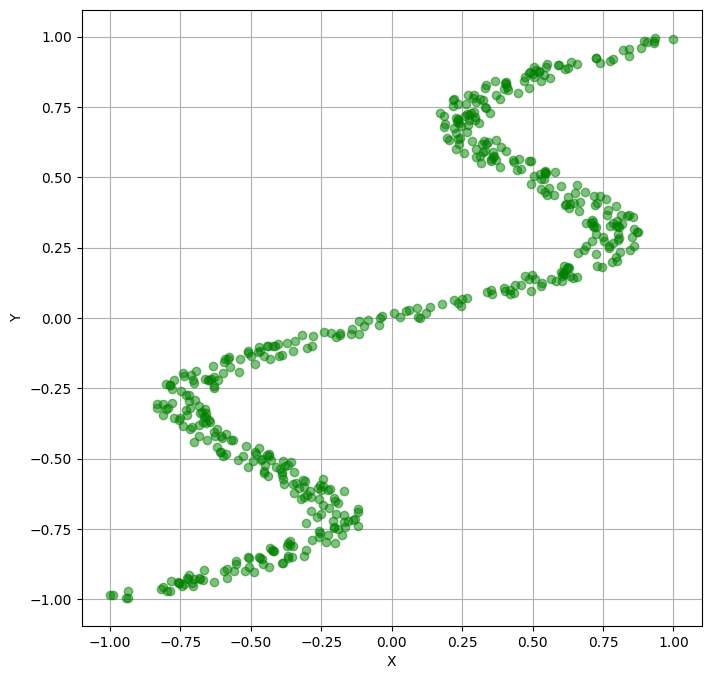

In [3]:
# Another example: inverse sine wave,
# a classic multi-modal output dataset introduced by (Bishop 1994) in Mixture density networks
# generate data
n = 500
d = 1
t = 1
y = np.random.uniform(-1, 1, (n, d)).astype(np.float32)
noise = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
x = y + 0.5 * np.sin(2 * np.pi * y) + noise

# Scale y_train to be in the range of -1 to 1
x = 2 * (x - x.min()) / (x.max() - x.min()) - 1


# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

fig = plt.figure(figsize=(8, 8))
plt.plot(x, y, 'go', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


In [4]:
# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# Discriminator modified to output raw logits instead of sigmoid
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            # Removed sigmoid to get raw logits
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)
    
def compute_discriminator_loss(discriminator, real_samples, fake_samples, condition):
    """Compute discriminator loss with gradient penalty"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)

    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)

    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))

    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))
    
    

def compute_discriminator_loss_with_grad_penal(discriminator, real_samples, fake_samples, condition, lambda_gp=1.0):
    """Compute discriminator loss with gradient penalty"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)
    
    # Compute log probabilities
    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)  # Add small epsilon to prevent log(0)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)
    
    # Average over batch
    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))
    
    # Gradient penalty
    interpolates = real_samples
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates, condition)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    
    loss += gradient_penalty
    
    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))

def compute_generator_loss(discriminator, fake_samples, condition):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples, condition)
    loss = -torch.mean(torch.log(torch.sigmoid(d_fake) + 1e-10))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            x_input = batch_x
            y_target = batch_y
            
            # Step 1: Update discriminator
            for _ in range(30):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size)
                
                # Generate fake samples
                fake_y_target = generator(z, x_input)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, y_target, fake_y_target.detach(), x_input
                )
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Step 2 & 3: Update generator
            z = torch.randn(x_input.size(0), generator.latent_size)
            fake_y_target = generator(z, x_input)
            g_loss = compute_generator_loss(discriminator, fake_y_target, x_input)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")



    
# Hyperparameters
latent_size = 0
hidden_size = 64
output_size = 1
condition_size = 1
num_epochs = 100
batch_size = 32
learning_rate_d = 0.0002
learning_rate_g = 0.00005

# Initialize models
generator = Generator(latent_size, hidden_size, output_size, condition_size)
discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

Epoch [1/100], Discriminator Loss: 0.7446, Generator Loss: 1.2551
Epoch [2/100], Discriminator Loss: 0.4640, Generator Loss: 1.7655
Epoch [3/100], Discriminator Loss: 0.2934, Generator Loss: 2.6258
Epoch [4/100], Discriminator Loss: 0.2628, Generator Loss: 2.4500
Epoch [5/100], Discriminator Loss: 0.5615, Generator Loss: 1.7460
Epoch [6/100], Discriminator Loss: 0.4273, Generator Loss: 1.9984
Epoch [7/100], Discriminator Loss: 1.0035, Generator Loss: 1.1714
Epoch [8/100], Discriminator Loss: 0.4626, Generator Loss: 1.8908
Epoch [9/100], Discriminator Loss: 0.2165, Generator Loss: 2.5253
Epoch [10/100], Discriminator Loss: 0.3673, Generator Loss: 2.0790
Epoch [11/100], Discriminator Loss: 0.2947, Generator Loss: 2.2361
Epoch [12/100], Discriminator Loss: 0.2913, Generator Loss: 2.2938
Epoch [13/100], Discriminator Loss: 0.5372, Generator Loss: 1.7520
Epoch [14/100], Discriminator Loss: 0.3814, Generator Loss: 2.2406
Epoch [15/100], Discriminator Loss: 0.3867, Generator Loss: 2.0868
Epoc

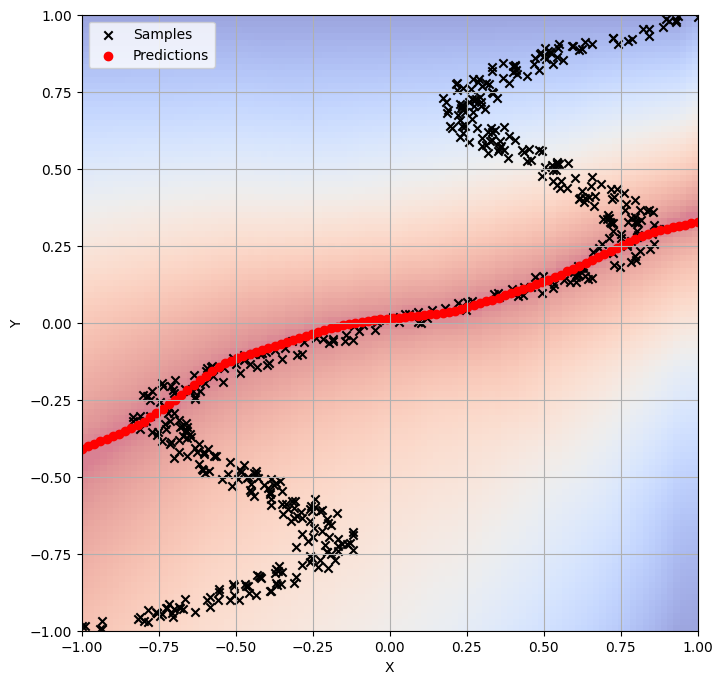

In [5]:
# Visualize the discriminator output heatmap and the predictions
# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions = generator(z, query_points_tensor).detach().numpy()

# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Compute discriminator output for each grid point
discriminator_outputs = []
for point in grid_points:
    x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
    y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
    output = discriminator(y_plot, x_plot).detach()
    # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
    discriminator_outputs.append(output.item())

# Reshape the outputs to match the grid
discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
# Normalize every column of the heatmap
discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

# As energy, take minus of the discriminator output
discriminator_outputs = -discriminator_outputs

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)
# cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)


# # Plot the function
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# for i, y_val in enumerate(y_vals_transposed):
#     ax.plot(x_vals, y_val,  linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=1)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
# plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()




Epoch [1/100], Generator Loss: 0.0126
Epoch [2/100], Generator Loss: -0.0000
Epoch [3/100], Generator Loss: -0.0000
Epoch [4/100], Generator Loss: 0.0000
Epoch [5/100], Generator Loss: 0.0387
Epoch [6/100], Generator Loss: 0.2243
Epoch [7/100], Generator Loss: 0.0000
Epoch [8/100], Generator Loss: 0.0000
Epoch [9/100], Generator Loss: 0.0042
Epoch [10/100], Generator Loss: -0.0000
Epoch [11/100], Generator Loss: 0.0000
Epoch [12/100], Generator Loss: 0.1493
Epoch [13/100], Generator Loss: -0.0000
Epoch [14/100], Generator Loss: -0.0000
Epoch [15/100], Generator Loss: 0.0083
Epoch [16/100], Generator Loss: 0.0005
Epoch [17/100], Generator Loss: 0.0039
Epoch [18/100], Generator Loss: 0.0000
Epoch [19/100], Generator Loss: 0.0070
Epoch [20/100], Generator Loss: 0.0000
Epoch [21/100], Generator Loss: 0.0185
Epoch [22/100], Generator Loss: 0.0002
Epoch [23/100], Generator Loss: 0.0438
Epoch [24/100], Generator Loss: 0.0357
Epoch [25/100], Generator Loss: 0.1058
Epoch [26/100], Generator Los

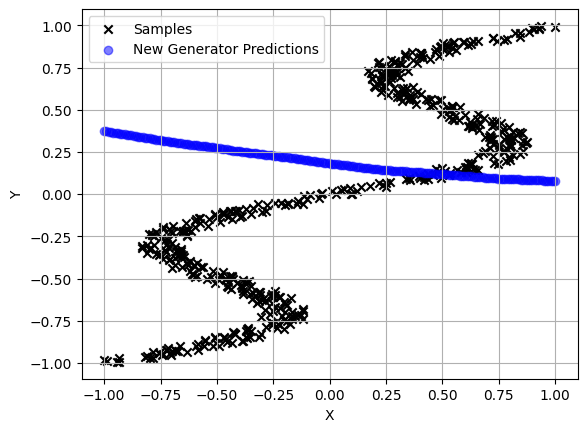

In [6]:
# Fix the discriminator and train a new generator
# Fix the discriminator parameters
for param in discriminator.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x
        y_target = batch_y
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_generator.latent_size)
        
        # Generate fake samples
        fake_y_target = new_generator(z, x_input)
        
        # Compute generator loss
        g_loss = compute_generator_loss(discriminator, fake_y_target, x_input)
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")
    
    
# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions_new = new_generator(z, query_points_tensor).detach().numpy()

# # Plot the function, samples, and predictions from new_generator
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# plt.figure(figsize=(8, 8))
# for i, y_val in enumerate(y_vals_transposed):
#     plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

In [7]:
# Define Energy-based Model using MLP
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    counter_samples = [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min for _ in range(neg_count)]
    return counter_samples

# Training loop
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)
            
            counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
            
            # Compute loss
            loss = criterion(model, x_input, y_target, counter_samples)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
# Hyperparameters
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
hidden_size = 64
num_epochs = 100
batch_size = 32
neg_count = 64
learning_rate = 0.001

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint y_target limits (radians)
y_max = torch.tensor([1])

# Initialize model, optimizer, scheduler
energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)
optimizer = optim.Adam(energy_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Train the model
train(energy_model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Loss: 4.1528, LR: 0.001000
Epoch [2/100], Loss: 4.0681, LR: 0.001000
Epoch [3/100], Loss: 3.9778, LR: 0.001000
Epoch [4/100], Loss: 3.8725, LR: 0.001000
Epoch [5/100], Loss: 3.7875, LR: 0.001000
Epoch [6/100], Loss: 3.7299, LR: 0.001000
Epoch [7/100], Loss: 3.6618, LR: 0.001000
Epoch [8/100], Loss: 3.6205, LR: 0.001000
Epoch [9/100], Loss: 3.5909, LR: 0.001000
Epoch [10/100], Loss: 3.5641, LR: 0.001000
Epoch [11/100], Loss: 3.5389, LR: 0.001000
Epoch [12/100], Loss: 3.5243, LR: 0.001000
Epoch [13/100], Loss: 3.4946, LR: 0.001000
Epoch [14/100], Loss: 3.4805, LR: 0.001000
Epoch [15/100], Loss: 3.4803, LR: 0.001000
Epoch [16/100], Loss: 3.4613, LR: 0.001000
Epoch [17/100], Loss: 3.4280, LR: 0.001000
Epoch [18/100], Loss: 3.4255, LR: 0.001000
Epoch [19/100], Loss: 3.4092, LR: 0.001000
Epoch [20/100], Loss: 3.4006, LR: 0.000500
Epoch [21/100], Loss: 3.3983, LR: 0.000500
Epoch [22/100], Loss: 3.3912, LR: 0.000500
Epoch [23/100], Loss: 3.3878, LR: 0.000500
Epoch [24/100], Loss

In [8]:
# Derivative-free optimizer for inference
def ebm_infer(energy_model, target_x_input, y_min, y_max, samples=16384, iterations=4, sigma_init=0.33, scale=0.5):
    """
    Find y_target that minimize energy for a given target x_input.

    Args:
        energy_model: Trained energy-based model.
        target_x_input: Target x_input (Cartesian coordinates), shape: (1, input_dim).
        y_min: Minimum values for joint y_target (tensor).
        y_max: Maximum values for joint y_target (tensor).
        samples: Number of random samples for initial exploration.
        iterations: Number of optimization iterations.
        sigma_init: Initial noise level for exploration.
        scale: Scaling factor for noise reduction.

    Returns:
        Optimal joint y_target minimizing the energy.
    """
    device = target_x_input.device
    target_x_input = target_x_input.repeat(samples, 1)  # Repeat for batch inference
    sigma = sigma_init

    # Initialize random joint y_target samples
    y_target = torch.rand((samples, y_min.size(-1)), device=device) * (y_max - y_min) + y_min

    for _ in range(iterations):
        # Compute energies for current samples
        # If energy_model is type EnergyModel, you can use energy_model(target_x_input, y_target)
        # elif energy_model is typr Discriminator, you can use -energy_model(y_target, target_x_input)
        if isinstance(energy_model, EnergyModel):
            energies = energy_model(target_x_input, y_target)
        elif isinstance(energy_model, Discriminator):
            energies = -energy_model(y_target, target_x_input)
        else:
            raise ValueError("Invalid energy model type.")

        # Softmax over negative energies for sampling probabilities
        probabilities = torch.softmax(-energies, dim=0)

        # Resample based on probabilities
        indices = torch.multinomial(probabilities, num_samples=samples, replacement=True)
        y_target = y_target[indices]

        # Add noise for exploration
        y_target += torch.randn_like(y_target) * sigma
        y_target = torch.clamp(y_target, y_min, y_max)  # Clamp to valid joint y_target bounds

        # Reduce noise scale
        sigma *= scale

    # Return the y_target corresponding to the minimum energy
    best_idx = torch.argmin(energies)
    return y_target[best_idx].unsqueeze(0)  # Shape: (1, action_dim)


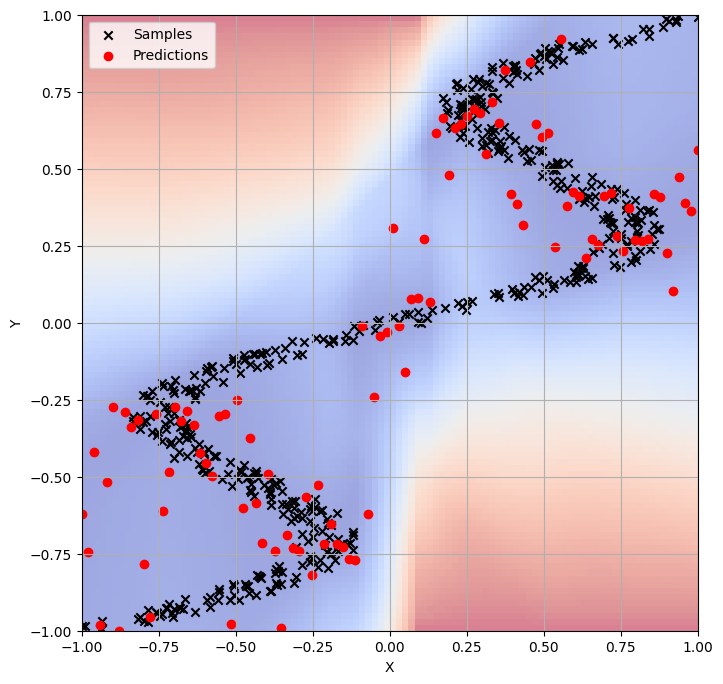

In [9]:

# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)

predictions = []
for point in query_points:
    query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
    prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
    predictions.append(prediction.item())


# Visualize the energy model output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# # Plot the function
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# for i, y_val in enumerate(y_vals_transposed):
#     ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=1)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
# plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
plt.show()




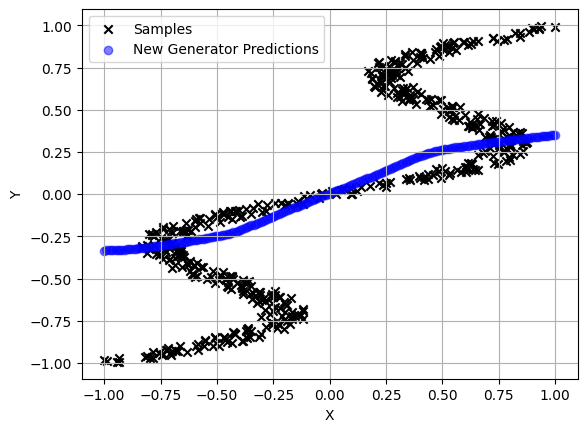

In [10]:
# Fixed the energy model and train a new generator
# Fix the energy model parameters
for param in energy_model.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x.to(device)
        y_target = batch_y.to(device)
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_generator.latent_size).to(device)
        
        # Generate fake samples using the generator and x_input
        fake_y_target = new_generator(z, x_input)
        
        # Compute generator loss
        g_loss = energy_model(x_input, fake_y_target).mean()
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    # print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")

# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_new = new_generator(z, query_points_tensor).detach().cpu().numpy()

# # Plot the function, samples, and predictions from new_generator
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# plt.figure(figsize=(8, 8))
# for i, y_val in enumerate(y_vals_transposed):
#     plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()


In [ ]:
# EBGAN: Energy-Based GAN
# Hyperparameters
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
condition_size = 1
hidden_size = 64


num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 1

learning_rate_e = 0.001
learning_rate_g = 0.0005

# Training loop combining energy model with GAN
def train_ebgan(model, generator, dataloader, criterion, optimizer_e, optimizer_g, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)
            
            for _ in range(repeat_energy_updates):
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            
                # Generate fake samples
                fake_y_target = generator(z, x_input)
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Append the fake samples to the counter samples
                counter_samples.append(fake_y_target)
                
                # Compute loss
                loss = criterion(model, x_input, y_target, counter_samples)
                
                # Backpropagation
                optimizer_e.zero_grad()
                loss.backward()
                optimizer_e.step()
                
                epoch_loss += loss.item()
                
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator(z, x_input)
            g_loss = model(x_input, fake_y_target).mean()
            
            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader) /repeat_energy_updates
        print(f"Epoch [{epoch+1}/{num_epochs}], Energy Loss: {avg_loss:.4f}, Generator Loss: {g_loss.item():.4f}")
       

# Initialize a new generator
ebgan_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
ebgan_energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)

# Optimizer
optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
optimizer_ebgan_g = optim.Adam(ebgan_generator.parameters(), lr=learning_rate_g)

# Train the ebgan model
train_ebgan(ebgan_energy_model, ebgan_generator, dataloader, info_nce_loss, optimizer_ebgan_e, optimizer_ebgan_g, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Energy Loss: 3.4775, Generator Loss: -3.3957
Epoch [2/100], Energy Loss: 3.3977, Generator Loss: -3.2830
Epoch [3/100], Energy Loss: 3.3124, Generator Loss: -2.9752
Epoch [4/100], Energy Loss: 3.2157, Generator Loss: -3.7926
Epoch [5/100], Energy Loss: 3.1368, Generator Loss: -2.9980
Epoch [6/100], Energy Loss: 3.0883, Generator Loss: -2.8356
Epoch [7/100], Energy Loss: 3.0552, Generator Loss: -3.8833
Epoch [8/100], Energy Loss: 3.0270, Generator Loss: -2.3350
Epoch [9/100], Energy Loss: 2.9879, Generator Loss: -3.6700
Epoch [10/100], Energy Loss: 2.9753, Generator Loss: -2.9916
Epoch [11/100], Energy Loss: 2.9417, Generator Loss: -3.5208
Epoch [12/100], Energy Loss: 2.9268, Generator Loss: -3.1565
Epoch [13/100], Energy Loss: 2.9005, Generator Loss: -3.1555
Epoch [14/100], Energy Loss: 2.8818, Generator Loss: -2.9112
Epoch [15/100], Energy Loss: 2.8650, Generator Loss: -3.3512
Epoch [16/100], Energy Loss: 2.8505, Generator Loss: -2.4253
Epoch [17/100], Energy Loss: 2.84

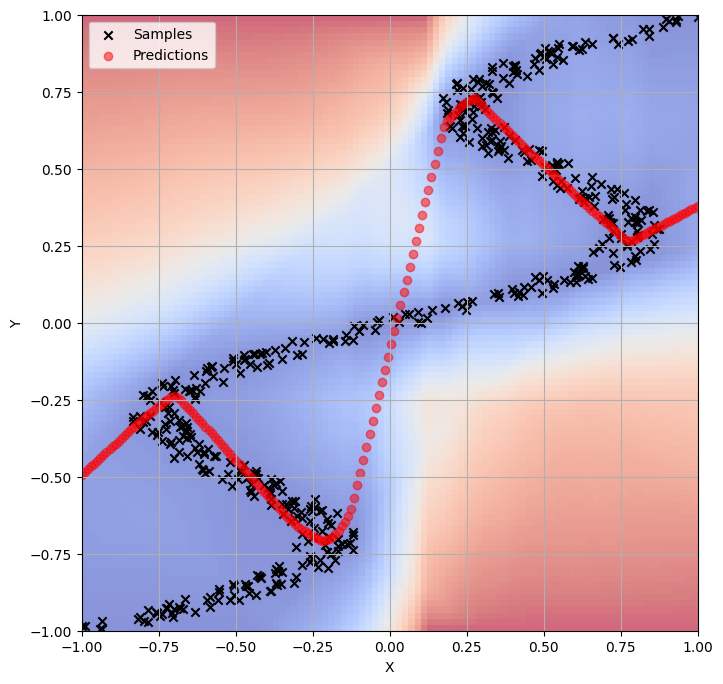

In [12]:
# Random sample the query points and get the predictions using ebgan_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_ebgan = ebgan_generator(z, query_points_tensor).detach().cpu().numpy()

# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = ebgan_energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# # Plot the function
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# for i, y_val in enumerate(y_vals_transposed):
#     ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions_ebgan, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
# plt.savefig('asset/proposal/hyperbola_ebgan.png', dpi=300)
plt.show()

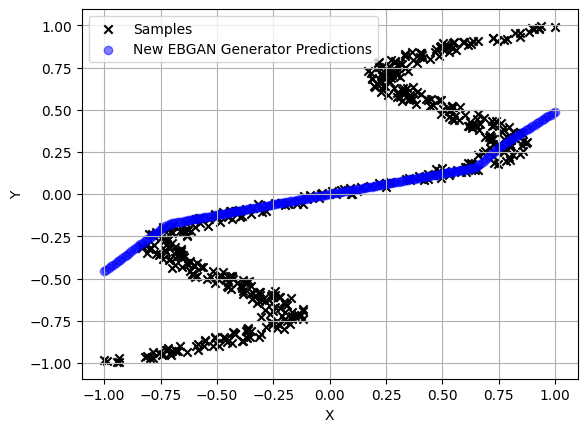

In [13]:
# Train new generator with with fixed ebgan_energy_model
# Fix the ebgan_energy_model parameters
for param in ebgan_energy_model.parameters():
    param.requires_grad = False

# Initialize a new generator
new_ebgan_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)

# Randomize the weights of the new generator
for param in new_ebgan_generator.parameters():
    nn.init.normal_(param, mean=0, std=0.2)
    

# Optimizer for the new generator
optimizer_new_ebgan_g = optim.Adam(new_ebgan_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_ebgan_g = 100
for epoch in range(num_epochs_new_ebgan_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x.to(device)
        y_target = batch_y.to(device)
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_ebgan_generator.latent_size).to(device)
        
        # Generate fake samples using the generator and x_input
        fake_y_target = new_ebgan_generator(z, x_input)
        
        # Compute generator loss
        g_loss = ebgan_energy_model(x_input, fake_y_target).mean()
        
        # Update generator
        optimizer_new_ebgan_g.zero_grad()
        g_loss.backward()
        optimizer_new_ebgan_g.step()
    
    # print(f"Epoch [{epoch+1}/{num_epochs_new_ebgan_g}], Generator Loss: {g_loss.item():.4f}")

# Random sample the query points and get the predictions using new_ebgan_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
z = torch.randn(num_query_points, latent_size).to(device)
predictions_new_ebgan = new_ebgan_generator(z, query_points_tensor).detach().cpu().numpy()

# # Plot the function, samples, and predictions from new_ebgan_generator
# x_vals = np.linspace(-1, 1, 100)
# y_vals = [y_multi(x_i) for x_i in x_vals]
# y_vals_transposed = list(zip(*y_vals))

# plt.figure(figsize=(8, 8))
# for i, y_val in enumerate(y_vals_transposed):
#     plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new_ebgan, marker='o', color='blue', label='New EBGAN Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

---

## 2D - Trajectories

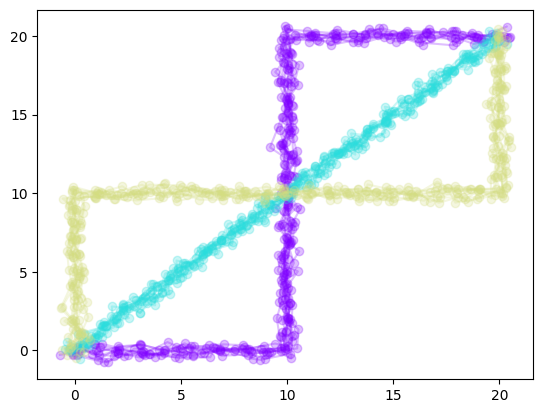

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

# https://github.com/notmahi/bet/blob/main/envs/multi_route/multi_route.py
from envs.multi_route.multi_route import PathGenerator, MULTI_PATH_WAYPOINTS_1

waypoints = MULTI_PATH_WAYPOINTS_1
traj_len_per = 10
path_generator = PathGenerator(waypoints, traj_len=traj_len_per)
path_generator.draw()

Types of random_paths: 3
Length of each random_paths: 40


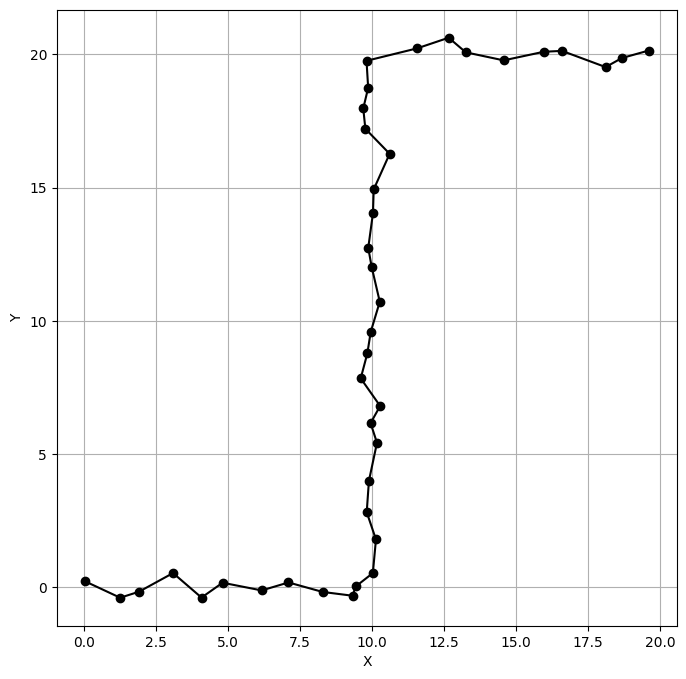

In [3]:
# Prepare the dataset

num_paths = 300
random_paths = path_generator.get_random_paths(num_paths, (0.5,0,0.5))
print("Types of random_paths:", len(random_paths))
traj_len = len(random_paths[0][0]) # should be traj_len_per * (num_waypoints - 1)
print ("Length of each random_paths:", traj_len) 

trajectories = np.concatenate(random_paths, axis=0)

# Load dataset
batch_size = 16
dataset = TensorDataset(torch.tensor(trajectories, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Visualize one of the trajectories
plt.figure(figsize=(8, 8))
path = trajectories[149]
plt.plot(path[:, 0], path[:, 1], marker='o', color='black')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Generator model using MLP
class Generator(nn.Module):
    def __init__(self, latent_size, output_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_size),
            # nn.Tanh()
        )

    def forward(self, x):
        x = torch.cat([x], dim=1)
        return self.model(x)

# Define the Discriminator model using MLP
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = torch.cat([x], dim=1)
        return self.model(x)

def compute_discriminator_loss(discriminator, real_samples, fake_samples):
    """Compute discriminator loss with gradient penalty"""
    
    # Get discriminator outputs
    d_real = discriminator(real_samples)
    d_fake = discriminator(fake_samples)

    log_prob_real = torch.log(d_real + 1e-15)
    log_prob_fake = torch.log(1 - d_fake + 1e-15)

    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))

    return loss, torch.mean(d_real), torch.mean(d_fake)

def compute_generator_loss(discriminator, fake_samples):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples)
    loss = -torch.mean(torch.log(d_fake + 1e-15))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch in dataloader:
            y_target = batch[0].to(device) 
            # flatten the input from (batch_size, traj_len, 2) to (batch_size, traj_len * 2)
            y_target = y_target.view(y_target.size(0), -1)
        
            # Step 1: Update discriminator
            for _ in range(10):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(y_target.size(0), generator.latent_size).to(device)
                
                # Generate fake samples
                fake_y_target = generator(z)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, y_target, fake_y_target.detach()
                )
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()
                
            for _ in range(2):
                # Step 2 & 3: Update generator
                z = torch.randn(y_target.size(0), generator.latent_size).to(device)
                fake_y_target = generator(z)
                g_loss = compute_generator_loss(discriminator, fake_y_target)
                
                optimizer_g.zero_grad()
                g_loss.backward()
                optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")

# Hyperparameters
latent_size = 2
hidden_size = 64
traj_len = 40  # Define traj_len
output_size = traj_len * 2 # x, y
num_epochs = 50

learning_rate_d = 0.0001
learning_rate_g = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define device

# Initialize models
generator = Generator(latent_size, output_size).to(device)
discriminator = Discriminator(output_size).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

NameError: name 'dataloader' is not defined

(20, 80)
(10, 40, 2)
Average Discriminator Score: 0.7296078205108643
Average Discriminator Score for Generated Trajectories: 0.5053758352994919


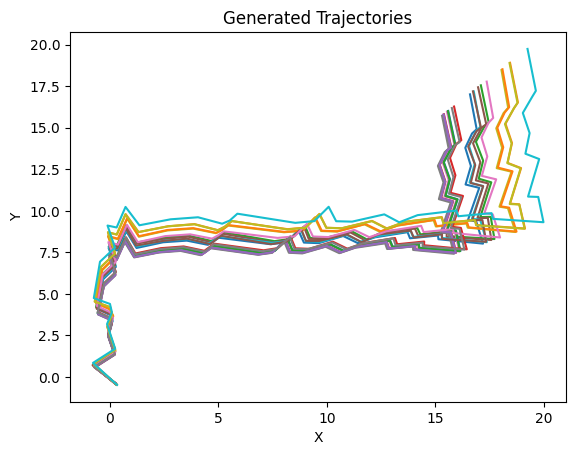

In [116]:
# Generate new trajectories
z = torch.randn(20, latent_size).to(device)
generated_trajectories = generator(z).detach().cpu().numpy()
print(generated_trajectories.shape)

# Generate some test trajectories using path_generator
num_paths = 20
test_paths = path_generator.get_random_paths(num_paths, (0.5,0,0.5))
test_paths = test_paths[2]
# test_paths = np.concatenate((test_paths[1]), axis=0)
print(test_paths.shape)

# Evaluate the test trajectories using the discriminator
test_paths = torch.tensor(test_paths, dtype=torch.float32).to(device)
test_paths = test_paths.view(test_paths.size(0), -1)
d_scores = []
for trajectory in test_paths:
    trajectory = trajectory.view(1, -1)
    d_score = torch.sigmoid(discriminator(trajectory)).item()
    # print(f"Discriminator score: {d_score}")
    d_scores.append(d_score)
    
print("Average Discriminator Score:", np.mean(d_scores))


# Evaluate the generated trajectories using the discriminator
# generated_trajectories = generated_trajectories.reshape(-1, traj_len, 2)
d_scores = []
for trajectory in generated_trajectories:
    trajectory = torch.tensor(trajectory, dtype=torch.float32).to(device)
    trajectory = trajectory.view(1, -1)
    d_score = torch.sigmoid(discriminator(trajectory)).item()
    d_scores.append(d_score)
    
print("Average Discriminator Score for Generated Trajectories:", np.mean(d_scores))
    

# Reverse the reshape process   
generated_trajectories = generated_trajectories.reshape(-1, traj_len, 2)

# Plot generated trajectories
for trajectory in generated_trajectories:
    plt.plot(trajectory[:,0], trajectory[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Trajectories')
plt.show()

Epoch [1/50], Loss: 13.8591
Epoch [2/50], Loss: 10.5037
Epoch [3/50], Loss: 8.9646
Epoch [4/50], Loss: 8.5447
Epoch [5/50], Loss: 8.2584
Epoch [6/50], Loss: 8.3469
Epoch [7/50], Loss: 8.7174
Epoch [8/50], Loss: 8.5364
Epoch [9/50], Loss: 7.5522
Epoch [10/50], Loss: 8.8690
Epoch [11/50], Loss: 9.7710
Epoch [12/50], Loss: 8.1778
Epoch [13/50], Loss: 8.7426
Epoch [14/50], Loss: 8.8579
Epoch [15/50], Loss: 8.1632
Epoch [16/50], Loss: 8.6708
Epoch [17/50], Loss: 8.8975
Epoch [18/50], Loss: 8.3418
Epoch [19/50], Loss: 9.1730
Epoch [20/50], Loss: 9.9749
Epoch [21/50], Loss: 8.4027
Epoch [22/50], Loss: 7.5622
Epoch [23/50], Loss: 8.1707
Epoch [24/50], Loss: 8.8006
Epoch [25/50], Loss: 7.7428
Epoch [26/50], Loss: 8.3936
Epoch [27/50], Loss: 9.0071
Epoch [28/50], Loss: 8.3003
Epoch [29/50], Loss: 9.3052
Epoch [30/50], Loss: 8.4144
Epoch [31/50], Loss: 8.2663
Epoch [32/50], Loss: 8.1864
Epoch [33/50], Loss: 9.2314
Epoch [34/50], Loss: 8.4345
Epoch [35/50], Loss: 8.8218
Epoch [36/50], Loss: 8.2082

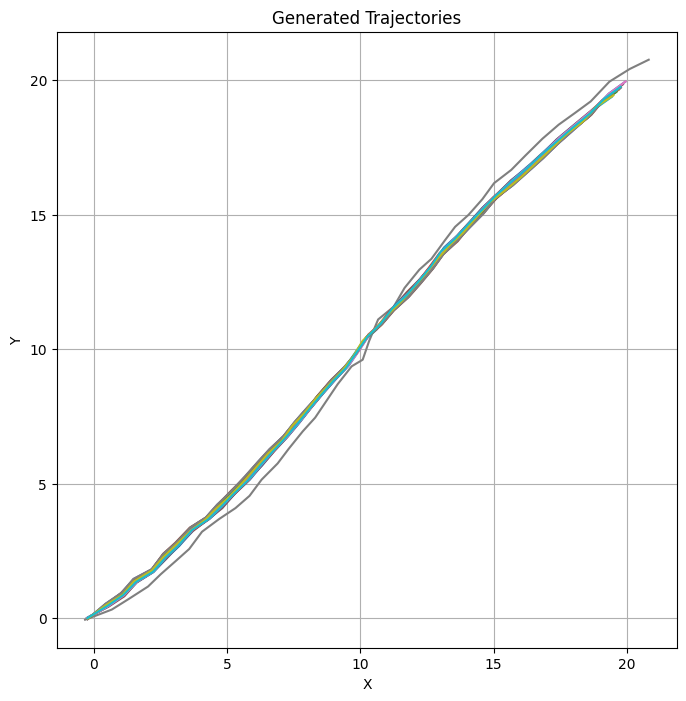

In [4]:
# MSE loss with MLP
class MLP(nn.Module):
    def __init__(self, latent_size, output_size):
        super(MLP, self).__init__()
        self.latent_size = latent_size
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_size),
            # nn.Tanh()
        )

    def forward(self, x):
        x = torch.cat([x], dim=1)
        return self.model(x)
    
# Prepare the dataset
num_paths = 300
random_paths = path_generator.get_random_paths(num_paths, (0.5,0,0.5))
trajectories = np.concatenate(random_paths, axis=0)

# Load dataset
batch_size = 16
dataset = TensorDataset(torch.tensor(trajectories, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
latent_size = 2
output_size = traj_len * 2
mlp = MLP(latent_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        y_target = batch[0].to(device)
        y_target = y_target.view(y_target.size(0), -1)
        
        # Draw noise samples
        z = torch.randn(y_target.size(0), latent_size).to(device)
        
        # Forward pass
        predictions = mlp(z)
        loss = criterion(predictions, y_target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Generate new trajectories
z = torch.randn(20, latent_size).to(device)
generated_trajectories = mlp(z).detach().cpu().numpy()
generated_trajectories = generated_trajectories.reshape(-1, traj_len, 2)

# Plot generated trajectories
plt.figure(figsize=(8, 8))
for trajectory in generated_trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Trajectories')
plt.grid()
plt.show()

---
## Multi_route

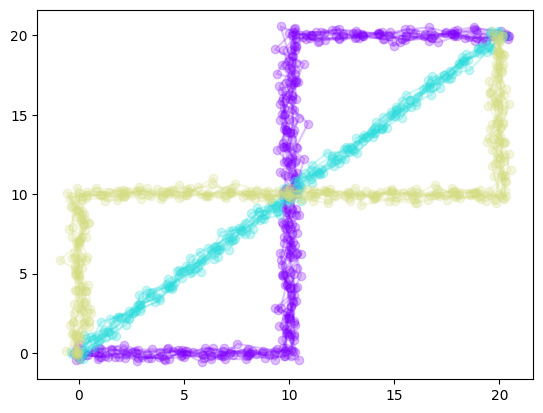

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

# https://github.com/notmahi/bet/blob/main/envs/multi_route/multi_route.py
from envs.multi_route.multi_route import PathGenerator, MULTI_PATH_WAYPOINTS_1

waypoints = MULTI_PATH_WAYPOINTS_1
step_size = 1
path_generator = PathGenerator(waypoints, step_size= step_size)
path_generator.draw()

In [5]:
# Prepare the dataset
num_paths = 200
full_obs_dataset, full_action_dataset = path_generator.get_memoryless_dataset(num_paths,(0.5,0,5))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert datasets to tensors
x_tensor = torch.tensor(full_obs_dataset, dtype=torch.float32).to(device)
y_tensor = torch.tensor(full_action_dataset, dtype=torch.float32).to(device)

# Create DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# Use a MLP to map the observation to the action, train it and plot the results
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = full_obs_dataset.shape[1]
hidden_size = 64
output_size = full_action_dataset.shape[1]
num_epochs = 100
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
mlp = MLP(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_x, batch_y in dataloader:
        # Forward pass
        predictions = mlp(batch_x)
        loss = criterion(predictions, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [20/100], Loss: 0.2367
Epoch [40/100], Loss: 0.1749
Epoch [60/100], Loss: 0.1092
Epoch [80/100], Loss: 0.1524
Epoch [100/100], Loss: 0.1106


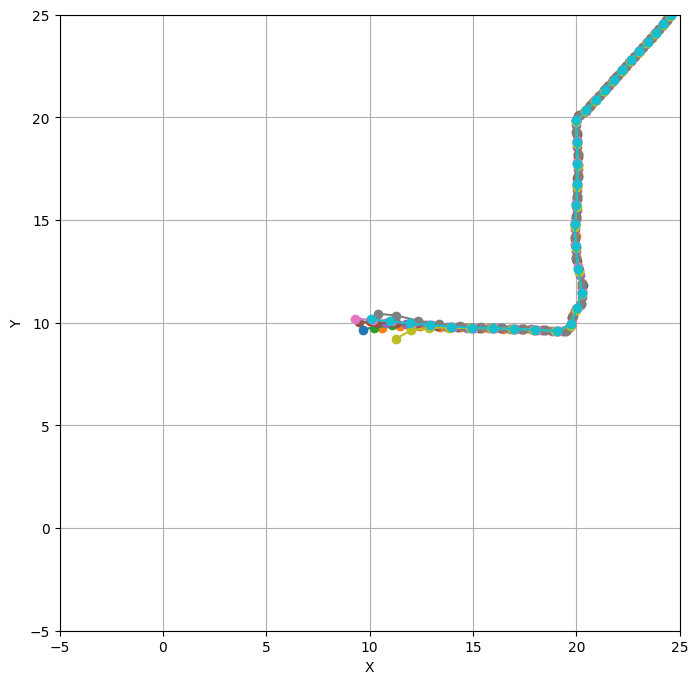

In [9]:
# Autoregressively generate a trajectory
def generate_trajectory(mlp, start_obs, num_steps):
    current_obs = start_obs
    trajectory = [current_obs.squeeze().cpu().detach().numpy()]
    
    for _ in range(num_steps):
        # Predict the action
        action = mlp(current_obs)
        
        # Update the observation
        current_obs = current_obs + action
        
        # Append to the trajectory
        trajectory.append(current_obs.squeeze().cpu().detach().numpy())
    
    return np.array(trajectory)

# Generate N trajectory around start_obs and plot it
N = 10
num_steps = 45
start_obs = torch.tensor([[10,10]], dtype=torch.float32).to(device)
trajectories = []

for _ in range(N):
    jittered_start_obs = start_obs + 0.6 * torch.randn_like(start_obs)
    trajectory = generate_trajectory(mlp, jittered_start_obs, num_steps)
    trajectories.append(trajectory)

# Plot the generated trajectories
plt.figure(figsize=(8, 8))
for trajectory in trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

In [31]:
# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)
    
def compute_discriminator_loss(discriminator, real_samples, fake_samples, condition):
    """Compute discriminator loss with gradient penalty"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)

    log_prob_real = torch.log(d_real + 1e-10)
    log_prob_fake = torch.log(1 - d_fake + 1e-10)

    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))

    return loss, torch.mean(d_real), torch.mean(d_fake)
    

def compute_generator_loss(discriminator, fake_samples, condition):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples, condition)
    loss = -torch.mean(torch.log(d_fake + 1e-10))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)
            
            # Step 1: Update discriminator
            for _ in range(10):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
                # Generate fake samples
                fake_y_target = generator(z, x_input)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, y_target, fake_y_target.detach(), x_input
                )
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Step 2 & 3: Update generator
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator(z, x_input)
            g_loss = compute_generator_loss(discriminator, fake_y_target, x_input)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")



    
# Hyperparameters
latent_size = 10
hidden_size = 64
output_size = 2
condition_size = 2
num_epochs = 100
batch_size = 32
learning_rate_d = 0.001
learning_rate_g = 0.0001

# Initialize models
generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
discriminator = Discriminator(output_size, hidden_size, 1, condition_size).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate_d)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

Epoch [1/100], Discriminator Loss: 0.9848, Generator Loss: 1.4852
Epoch [2/100], Discriminator Loss: 0.9608, Generator Loss: 0.8050
Epoch [3/100], Discriminator Loss: 1.4913, Generator Loss: 1.1531
Epoch [4/100], Discriminator Loss: 0.8559, Generator Loss: 1.0403
Epoch [5/100], Discriminator Loss: 1.3153, Generator Loss: 0.9241
Epoch [6/100], Discriminator Loss: 0.8644, Generator Loss: 0.7786
Epoch [7/100], Discriminator Loss: 1.4600, Generator Loss: 0.3203
Epoch [8/100], Discriminator Loss: 1.1692, Generator Loss: 0.5510
Epoch [9/100], Discriminator Loss: 1.1909, Generator Loss: 0.5222
Epoch [10/100], Discriminator Loss: 1.4035, Generator Loss: 0.9028
Epoch [11/100], Discriminator Loss: 1.0895, Generator Loss: 0.8120
Epoch [12/100], Discriminator Loss: 1.4261, Generator Loss: 0.6978
Epoch [13/100], Discriminator Loss: 1.1822, Generator Loss: 0.8045
Epoch [14/100], Discriminator Loss: 1.5482, Generator Loss: 0.7601
Epoch [15/100], Discriminator Loss: 1.3221, Generator Loss: 0.9279
Epoc

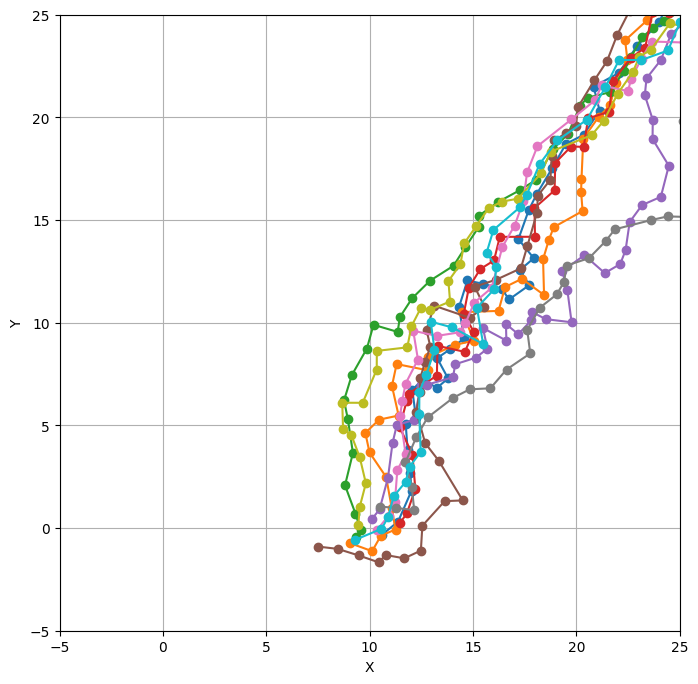

In [33]:
# write a function to generate a trajectory using the generator
def generate_trajectory(generator, start_obs, num_steps):
    current_obs = start_obs
    trajectory = [current_obs.squeeze().cpu().detach().numpy()]
    
    for _ in range(num_steps):
        # Draw noise samples
        z = torch.randn(1, generator.latent_size).to(device)
        
        # Generate fake samples
        fake_y_target = generator(z, current_obs)
        
        # Update the observation
        current_obs = current_obs + fake_y_target
        
        # Append to the trajectory
        trajectory.append(current_obs.squeeze().cpu().detach().numpy())
    
    return np.array(trajectory)

# Generate N trajectory around start_obs and plot it
N = 10
num_steps = 40
start_obs = torch.tensor([[10,0]], dtype=torch.float32).to(device)
trajectories = []

for _ in range(N):
    jittered_start_obs = start_obs + 1 * torch.randn_like(start_obs)
    trajectory = generate_trajectory(generator, jittered_start_obs, num_steps)
    trajectories.append(trajectory)

# Plot the generated trajectories
plt.figure(figsize=(8, 8))
for trajectory in trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

In [56]:
# EBGAN: Energy-Based GAN
# Define Energy-based Model using MLP
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)
    
# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)
    
# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    counter_samples = [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min for _ in range(neg_count)]
    return counter_samples

# Hyperparameters
latent_size = 0  # x, y x_input
output_size = 2  # joint y_target
condition_size = 2
hidden_size = 64

num_epochs = 100

neg_count = 32
repeat_energy_updates = 2

learning_rate_e = 0.001
learning_rate_g = 0.0005

# Training loop combining energy model with GAN
def train_ebgan(energy_model, generator, dataloader, criterion, optimizer_e, optimizer_g, num_epochs, y_min, y_max, neg_count, device):
    energy_model.train()
    generator.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)
            
            for _ in range(repeat_energy_updates):
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            
                # Generate fake samples
                fake_y_target = generator(z, x_input)
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Append the fake samples to the counter samples
                counter_samples.append(fake_y_target)
                
                # Compute loss
                loss = criterion(energy_model, x_input, y_target, counter_samples)
                
                # Backpropagation
                optimizer_e.zero_grad()
                loss.backward()
                optimizer_e.step()
                
                epoch_loss += loss.item()
                
            # Update generator
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator(z, x_input)
            g_loss = energy_model(x_input, fake_y_target).mean()
            
            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        
        avg_loss = epoch_loss / len(dataloader) /repeat_energy_updates
        print(f"Epoch [{epoch+1}/{num_epochs}], Energy Loss: {avg_loss:.4f}, Generator Loss: {g_loss.item():.4f}")
       

# Initialize a new generator
ebgan_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

# Optimizer
optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
optimizer_ebgan_g = optim.Adam(ebgan_generator.parameters(), lr=learning_rate_g)


# Determine the range of y_target values from the dataset
y_min = torch.min(y_tensor, dim=0).values
y_max = torch.max(y_tensor, dim=0).values
print("y_min:", y_min)
print("y_max:", y_max)

# Train the ebgan model
train_ebgan(ebgan_energy_model, ebgan_generator, dataloader, info_nce_loss, optimizer_ebgan_e, optimizer_ebgan_g, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


y_min: tensor([-1.2500, -1.2589], device='cuda:0')
y_max: tensor([2.3721, 2.3642], device='cuda:0')
Epoch [1/100], Energy Loss: 2.6518, Generator Loss: -3.1531
Epoch [2/100], Energy Loss: 2.3903, Generator Loss: 2.5444
Epoch [3/100], Energy Loss: 2.3123, Generator Loss: 0.2932
Epoch [4/100], Energy Loss: 2.2900, Generator Loss: 0.8014
Epoch [5/100], Energy Loss: 2.2530, Generator Loss: -1.0959
Epoch [6/100], Energy Loss: 2.2230, Generator Loss: 1.0068
Epoch [7/100], Energy Loss: 2.2082, Generator Loss: 0.7492
Epoch [8/100], Energy Loss: 2.1865, Generator Loss: -0.8579
Epoch [9/100], Energy Loss: 2.1884, Generator Loss: -0.3764
Epoch [10/100], Energy Loss: 2.1697, Generator Loss: 1.3080
Epoch [11/100], Energy Loss: 2.1762, Generator Loss: 2.3060
Epoch [12/100], Energy Loss: 2.1488, Generator Loss: 2.6222
Epoch [13/100], Energy Loss: 2.1445, Generator Loss: -3.5966
Epoch [14/100], Energy Loss: 2.1369, Generator Loss: 0.7987
Epoch [15/100], Energy Loss: 2.1420, Generator Loss: 0.1825
Epoc

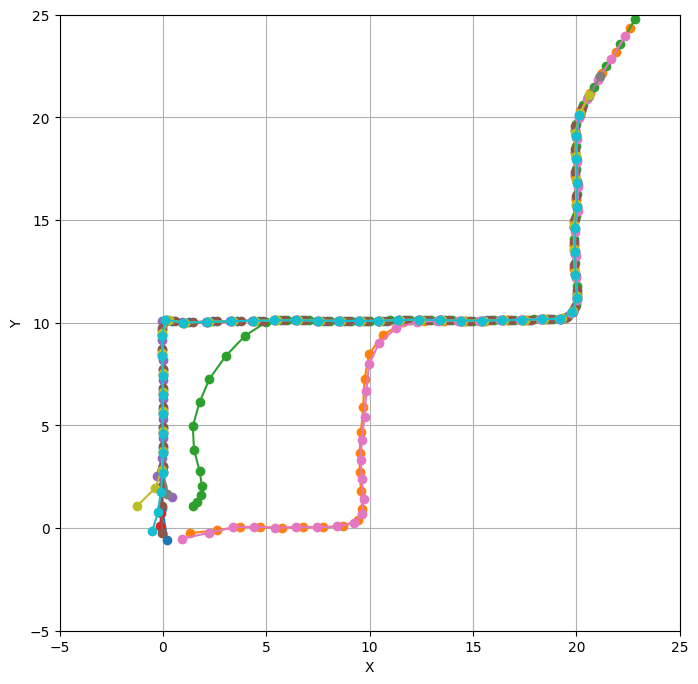

In [53]:
# write a function to generate a trajectory using the generator
def generate_trajectory(generator, start_obs, num_steps):
    current_obs = start_obs
    trajectory = [current_obs.squeeze().cpu().detach().numpy()]
    
    for _ in range(num_steps):
        # Draw noise samples
        z = torch.randn(1, generator.latent_size).to(device)
        
        # Generate fake samples
        fake_y_target = generator(z, current_obs)
        
        # Update the observation
        current_obs = current_obs + fake_y_target
        
        # Append to the trajectory
        trajectory.append(current_obs.squeeze().cpu().detach().numpy())
    
    return np.array(trajectory)

# Generate N trajectory around start_obs and plot it
N = 10
num_steps = 40
start_obs = torch.tensor([[0, 0]], dtype=torch.float32).to(device)
trajectories = []

for _ in range(N):
    jittered_start_obs = start_obs + 1 * torch.randn_like(start_obs)
    trajectory = generate_trajectory(ebgan_generator, jittered_start_obs, num_steps)
    trajectories.append(trajectory)

# Plot the generated trajectories
plt.figure(figsize=(8, 8))
for trajectory in trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

In [28]:
# Fix the ebgan_energy_model parameters and train a new generator
for param in ebgan_energy_model.parameters():
    param.requires_grad = False

# Initialize a new generator
new_ebgan_generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)

# Optimizer for the new generator
optimizer_new_ebgan_g = optim.Adam(new_ebgan_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_ebgan_g = 100
for epoch in range(num_epochs_new_ebgan_g):
    for batch_x, batch_y in dataloader:
        x_input = batch_x.to(device)
        y_target = batch_y.to(device)
        
        # Draw noise samples
        z = torch.randn(x_input.size(0), new_ebgan_generator.latent_size).to(device)
        
        # Generate fake samples using the generator and x_input
        fake_y_target = new_ebgan_generator(z, x_input)
        
        # Compute generator loss
        g_loss = ebgan_energy_model(x_input, fake_y_target).mean()
        
        # Update generator
        optimizer_new_ebgan_g.zero_grad()
        g_loss.backward()
        optimizer_new_ebgan_g.step()

In [ ]:
# Generate N trajectory around start_obs and plot it
N = 10
num_steps = 40
start_obs = torch.tensor([[0, 0]], dtype=torch.float32).to(device)
trajectories = []

for _ in range(N):
    jittered_start_obs = start_obs + 1 * torch.randn_like(start_obs)
    trajectory = generate_trajectory(new_ebgan_generator, jittered_start_obs, num_steps)
    trajectories.append(trajectory)

# Plot the generated trajectories
plt.figure(figsize=(8, 8))
for trajectory in trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.xlim(-5, 25)
plt.ylim(-5, 25)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()